In [1]:
import os
import numpy as np
import csv
import keras
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import yfinance as yf
import math
import time
import sklearn.metrics
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import Sequential
from keras.models import Sequential

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [4]:
cpy_tweet = pd.read_csv('Company_Tweet.csv')

In [5]:
tweet = pd.read_csv('Tweet.csv')

In [6]:
tweets = pd.merge(tweet,cpy_tweet,on='tweet_id',how='inner')
tweets.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL


In [7]:
tweets['post_date'] = pd.to_datetime(tweets['post_date'], unit='s')
tweets['date'] = pd.to_datetime(tweets['post_date'].apply(lambda date: date.date()))
tweets['date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: date, dtype: datetime64[ns]

In [8]:
all_tweets = tweets.drop(['tweet_id', 'writer', 'post_date'],axis=1)

In [9]:
all_tweets.isna().sum()

body             0
comment_num      0
retweet_num      0
like_num         0
ticker_symbol    0
date             0
dtype: int64

In [10]:
tweets.ticker_symbol.value_counts()

AAPL     1425013
TSLA     1096868
AMZN      718715
GOOG      392569
MSFT      375711
GOOGL     327569
Name: ticker_symbol, dtype: int64

In [11]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [12]:
def initialize_dataframe(df):
    sent_df = df.copy()
    sent_df["sentiment_score"] = ''
    sent_df["Negative"] = ''
    sent_df["Neutral"] = ''
    sent_df["Positive"] = ''
    sent_df.head()
    return sent_df

In [13]:
def sentiment_score(sent_df, sentiment_analyzer):
    for indx, row in sent_df.T.iteritems():
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'body'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    return sent_df

In [14]:
def process_data_frame(sent_df):
    sent_df2 = sent_df.copy() # default:true
    sent_df2['date'] = pd.to_datetime(sent_df2['date'])
    sent_df2['sentiment_score'] = pd.to_numeric(sent_df2['sentiment_score'], errors='coerce')
    sent_df2 = sent_df2[['date', 'body', 'sentiment_score']]
    return sent_df2

In [15]:
def avg_sentiment_scores(sent_df2):
    twitter_df = sent_df2.groupby([sent_df2['date']]).mean()
    return twitter_df

In [16]:
# Combine sentiment scores with stock price data
def combine_data(sp500_data,twitter_df,column):
    sp500_data[column] = 0
    for date in sp500_data.index:
        date_str = date.strftime('%Y-%m-%d')
        for i in range(len(twitter_df)):
            if twitter_df.index[i].strftime('%Y-%m-%d')  == date_str:
                sp500_data.at[date, column] = twitter_df['sentiment_score'][i]
    return sp500_data

In [17]:
sp500_data = pd.read_csv('S&P500_new.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

In [18]:
inflation_rate = pd.read_csv('InflationRates_fred.csv')
inflation_rate['Date'] = pd.to_datetime(inflation_rate['Date'])

In [19]:
sp500_data = pd.merge(sp500_data,inflation_rate,on='Date',how='left')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

In [20]:
x = inflation_rate['Rate'].median()
sp500_data['Rate'].fillna(x, inplace=True)

In [21]:
stock_name = 'AMZN'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

(718715, 6)


,body,comment_num,retweet_num,like_num,ticker_symbol,date
2,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01
27,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2,AMZN,2015-01-01
37,RT @SeekingAlpha: A Look At BlackBerry's Deals...,0,0,0,AMZN,2015-01-01
38,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57,AMZN,2015-01-01
39,Jeff Bezos lost $7.4 billion in #Amazon worst ...,1,2,1,AMZN,2015-01-01


In [22]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [23]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_amzn')

In [24]:
stock_name = 'AAPL'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

(1425013, 6)


,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01
1,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01
4,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01
6,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01
8,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01


In [25]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [26]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_aapl')

In [27]:
stock_name = 'MSFT'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

(375711, 6)


,body,comment_num,retweet_num,like_num,ticker_symbol,date
19,$UNP $ORCL $QCOM $MSFT $AAPL Top scoring mega ...,0,0,0,MSFT,2015-01-01
43,"http://StockAviator.com....Top penny stocks, N...",0,0,0,MSFT,2015-01-01
46,Want alerts for momentum stocks about to run? ...,0,0,0,MSFT,2015-01-01
75,"IMHO, $MSFT shockingly remains MILDLY undervalued",1,0,0,MSFT,2015-01-01
82,@CNNMoney I like $MSFT with him in charge. He ...,0,0,0,MSFT,2015-01-01


In [28]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [29]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_msft')

In [30]:
stock_name = 'GOOGL'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

(327569, 6)


,body,comment_num,retweet_num,like_num,ticker_symbol,date
30,2014 The Year in Review (Part II - THE END) ht...,0,2,2,GOOGL,2015-01-01
59,Prediction: $TWTR $GRPN $YELP are acquired as ...,0,0,1,GOOGL,2015-01-01
62,Prediction: PayPal post-spinoff and $PAY are n...,0,0,0,GOOGL,2015-01-01
72,Trailing Stop taken out on my $GOOGL #trade ta...,0,0,0,GOOGL,2015-01-01
87,#SENTISHIFTUP $X $T $GOOGL $AMRN $UPIP $CNAT $...,0,0,0,GOOGL,2015-01-01


In [31]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [32]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_googl')

In [33]:
corr_matrix = sp500_data.corr()
corr_matrix['Close'].sort_values(ascending = False)

Close        1.000000
Adj Close    1.000000
Low          0.999466
High         0.999314
Open         0.998770
ss_aapl      0.625639
ss_msft      0.560121
ss_googl     0.545013
Rate         0.501721
ss_amzn      0.490895
Volume      -0.205891
Name: Close, dtype: float64

In [34]:
sp500_data.to_csv('sp500_data.csv')

In [35]:
# Select the input features and target variable
features = ['Open','Close', 'ss_amzn', 'ss_aapl', 'ss_msft', 'ss_googl', 'Rate' ]

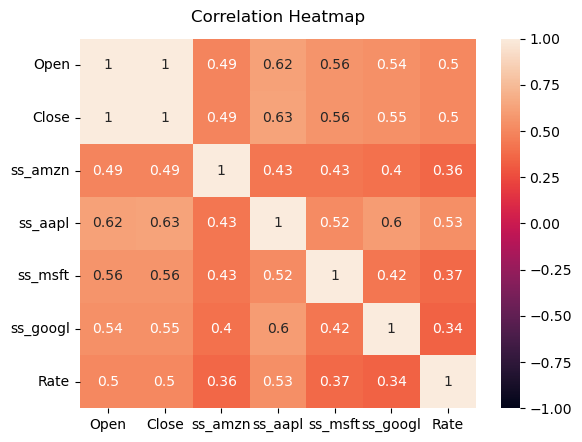

In [36]:
import seaborn as sns
heatmap = sns.heatmap(sp500_data[features].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [37]:
dataset = sp500_data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.9)
training_data_len

1132

In [38]:
#Scale the data
data = sp500_data
scaler = MinMaxScaler(feature_range = (0,1))
data[features] = scaler.fit_transform(data[features] )


In [39]:
#Create the training dataset
train_data = data.iloc[:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i][features].values)
    y_train.append(train_data[i:i+1]['Close'].values)
    if i<=61:
        print(x_train)
        print(y_train)


[array([[0.15949576, 0.16238818, 0.39508511, 0.2420562 , 0.69243069,
        0.39908833, 0.53      ],
       [0.15634123, 0.13572511, 0.51516898, 0.33666389, 0.55575535,
        0.96148548, 0.46      ],
       [0.13350262, 0.12298894, 0.42063351, 0.3662851 , 0.54775272,
        1.        , 0.38      ],
       [0.12176148, 0.1394957 , 0.24616847, 0.35658958, 0.59300359,
        0.84537092, 0.39      ],
       [0.13948634, 0.16518061, 0.38613833, 0.38855041, 0.71565298,
        0.67535736, 0.44      ],
       [0.162714  , 0.15289813, 0.41288599, 0.34129285, 0.55108639,
        0.5906138 , 0.44      ],
       [0.15046363, 0.14116833, 0.51127246, 0.35723595, 0.72494744,
        0.55805795, 0.39      ],
       [0.1401724 , 0.1374616 , 0.49764671, 0.36572394, 0.67943294,
        0.60776981, 0.36      ],
       [0.13085025, 0.12912672, 0.42135848, 0.27027179, 0.55133719,
        0.32288248, 0.39      ],
       [0.12756129, 0.11594404, 0.37301085, 0.2133143 , 0.62920638,
        0.39453161, 0.

In [40]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [41]:
np.random.seed(123)

In [42]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [43]:
#Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss='mean_squared_error')

In [44]:
es = tensorflow.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)

In [45]:
#Train the model
model.fit(x_train,y_train,batch_size = 16, validation_split = 0.2, epochs = 10, callbacks = [es])

Epoch 1/10
54/54 [==============================] - 6s 48ms/step - loss: 0.0373 - val_loss: 0.0027
Epoch 2/10
54/54 [==============================] - 2s 37ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 3/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/10
54/54 [==============================] - 2s 37ms/step - loss: 9.7125e-04 - val_loss: 0.0019
Epoch 5/10
54/54 [==============================] - 2s 36ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 6/10
54/54 [==============================] - 2s 36ms/step - loss: 7.7646e-04 - val_loss: 0.0023
Epoch 7/10
54/54 [==============================] - 2s 35ms/step - loss: 7.4367e-04 - val_loss: 0.0025
Epoch 8/10
54/54 [==============================] - 2s 35ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 9/10
54/54 [==============================] - 2s 35ms/step - loss: 7.8569e-04 - val_loss: 0.0013
Epoch 10/10
54/54 [==============================] - 2s 38ms/step - loss: 7.3734e-04 - val_lo

<AxesSubplot:>

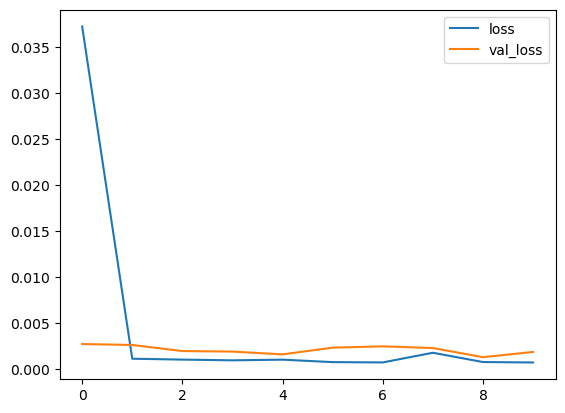

In [46]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [47]:
#Create the testing data set
#Create a new array containing scaled values from last 60 index
test_data = data.iloc[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len-60:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i][features].values)

In [48]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [49]:
#Get the models predicted price values
predictions = model.predict(x_test)

4/4 [==============================] - 1s 17ms/step


In [50]:
predicted1 = np.repeat(predictions, len(features), axis = -1)
predicted_descaled= scaler.inverse_transform(predicted1)[:, 0]

In [51]:
symbol = "^GSPC"
df1 = yf.download(symbol, start='2015-01-01', end='2019-12-31',interval = "1d")
df1.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [52]:
y_test = df1.iloc[training_data_len:, :]

In [53]:
y_test = y_test['Close']

In [54]:
predicted_descaled.shape

(125,)

In [56]:
mse = sklearn.metrics.mean_squared_error(y_test, predicted_descaled)
rmse = math.sqrt(mse)
rmse

54.77330675607534

In [57]:
def print_mean_absolute_percentage_error(y_test, predicted_descaled): 
    mape = np.mean(np.abs((y_test - predicted_descaled) / y_test)) * 100
    print('mape = ', mape)

print_mean_absolute_percentage_error(y_test, predicted_descaled)

mape =  1.4949808728802294


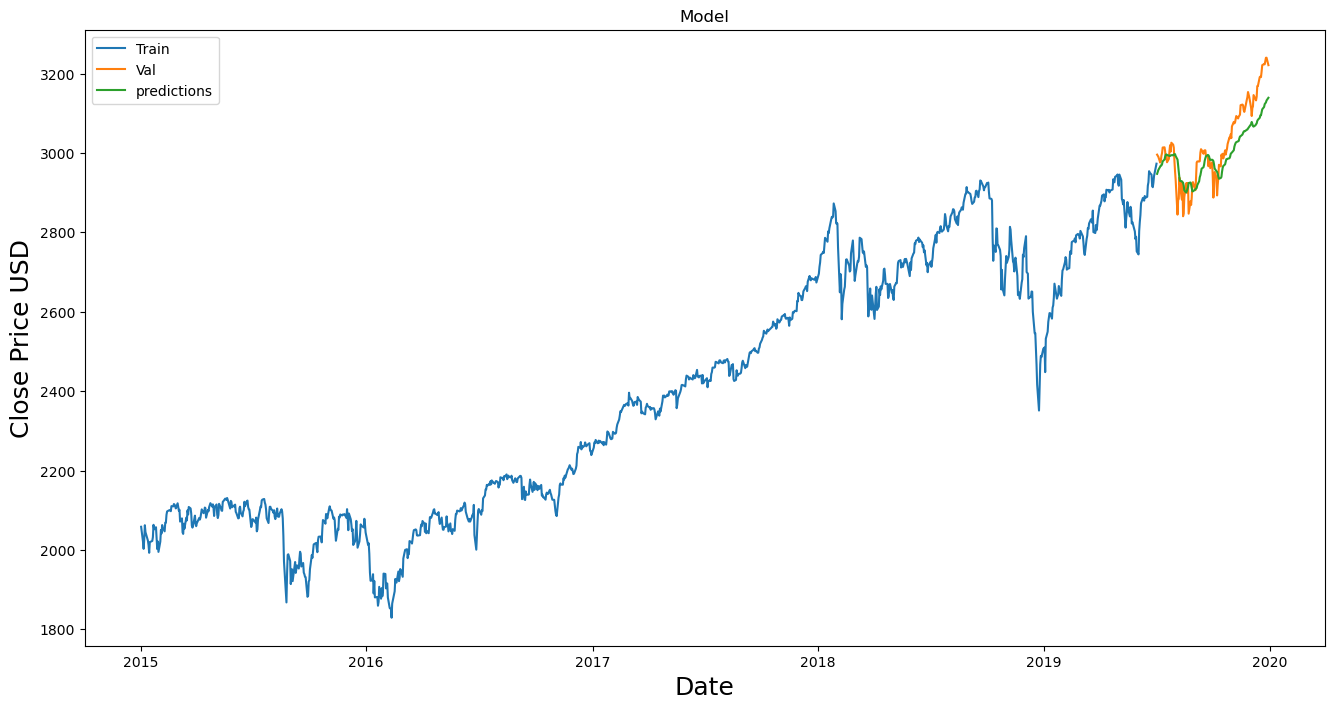

In [58]:
#Plot the data
data_set = df1.filter(['Close'])
train = data_set[:training_data_len]
valid = data_set[training_data_len:]
valid['Predictions'] = predicted_descaled
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','predictions'])
plt.show()

In [59]:
#Grid Search
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [60]:
# # Function to create model, required for KerasClassifier
def create_model(dropout_rate = 0.0):
    # create model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],len(features))))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())
    return model

In [62]:
# fix random seed for reproducibility
seed = 128
np.random.seed(seed)

model = KerasRegressor(build_fn=create_model, verbose=1, batch_size=16)
# define the grid search parameters
# batch_size = [128]
epochs = [10, 50]
dropout_rate = [0.1]
param_grid = dict(dropout_rate = dropout_rate,epochs = epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
67/67 [==============================] - 5s 31ms/step - loss: 0.0171 - accuracy: 9.3284e-04
Epoch 2/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0015 - accuracy: 9.3284e-04
Epoch 3/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0014 - accuracy: 9.3284e-04
Epoch 4/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0012 - accuracy: 9.3284e-04
Epoch 5/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0013 - accuracy: 9.3284e-04
Epoch 6/50
67/67 [==============================] - 2s 30ms/step - loss: 0.0012 - accuracy: 9.3284e-04
Epoch 7/50
67/67 [==============================] - 2s 29ms/step - loss: 0.0012 - accuracy: 9.3284e-04
Epoch 8/50
67/67 [==============================] - 2s 31ms/step - loss: 0.0012 - accuracy: 9.3284e-04
Epoch 9/50
67/67 [==============================] - 2s 31ms/step - loss: 0.0011 - accuracy: 9.3284e-04
Epoch 10/50
67/67 [==============================] - 2s 32ms/step - loss: